# Import of libreries

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)

# Import the raw data of Proyect Long-term energy environment data for ORNL Research House

In [8]:
#Data import 
DataFolderPath = "/Users/Marrugo/Dropbox/git_for_clone/Ac consumption prediction of ORNL Research House--MARRUGO--THOUVENIN/data_Oak_Ride_National_Laboratory.csv"
DF_Data_RAW = pd.read_csv(DataFolderPath,sep = ",",index_col=0) 

/Users/Marrugo/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (68,71,83,84,101) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Convert the index of the Data in datatime type

In [10]:
previousIndex= DF_Data_RAW.index
NewparsedIndex = pd.to_datetime(previousIndex)
DF_Data_RAW.index= NewparsedIndex

# Definition of functions

Function of lagged data for one column

In [16]:
def lag_column(df,column_name,lag_period=1):
    for i in range(1,lag_period+1,1):
        new_column_name = column_name+"-"+str(i)+"hour"
        df[new_column_name]=df[column_name].shift(i)
    return df

Function of lagged data for all columns

In [18]:
def lag_columnall(df,delay,lag_period=1):
    for column_name in df.columns.tolist():
        for i in range(1*delay,lag_period+delay-1,1):
            new_column_name = column_name+"-"+str(i)+"hour"
            df[new_column_name]=df[column_name].shift(i)
    return df

Function of time features for the data 

In [4]:
def features_creation(df):
    # creatures time based features from pandas dataframe
    # such hour of day, weekday/weekend, day/night and so on
    # sin hour and cos hour as just indirect representation of time of day
    df['sin_hour'] = np.sin((df.index.hour)*2*np.pi/24)
    df['cos_hour'] = np.cos((df.index.hour)*2*np.pi/24)#later try 24 vector binary format
    df['hour'] = df.index.hour # 0 to 23
    df['minute'] = df.index.minute # 00 to 59
    df['day_of_week'] = df.index.dayofweek #Monday = 0, sunday = 6
    df['weekend'] = [ 1 if day in (5, 6) else 0 for day in df.index.dayofweek ] # 1 for weekend and 0 for weekdays
    df['month'] = df.index.month
    df['week_of_year'] = df.index.week
    # day = 1 if(10Hrs -19Hrs) and Night = 0 (otherwise)
    df['day_night'] = [1 if day<20 and day>9 else 0 for day in df.index.hour ]
    return df

# Converting data from 15 min samplesto 1h samples

Adding time features to the data

In [68]:
#RAW data with time features
DF_Data_features=features_creation(DF_Data_RAW)

Selecting the data for each hour (#:00) where # is from 0 to 23

In [69]:
#Selecting the data of each hour
DF_Data_hour=DF_Data_features.loc[DF_Data_features['minute'] == 0]

Deleting time features

In [70]:
#Deleting the time features
DF_data_raw_hour=DF_Data_hour.drop(["RECORD","sin_hour","hour","minute","cos_hour","day_of_week","weekend","month","week_of_year","day_night"],axis=1)


Creating a copy of the data

In [71]:
#creating copy for the data
DF_data_raw_24=DF_data_raw_hour.copy()

# Creating lagged data for 9 hours

In [19]:
#Data lagged for 9 hours
DF_data_raw_hour_lagged=lag_columnall(DF_data_raw_hour,1,9)
#Data type conversion
DF_for_correlation=DF_data_raw_hour_lagged.astype("float64")

# Correlation of the lagged data

Correlating the data

In [95]:
#correlation of data
correlation=DF_for_correlation.corr()

Saving the correlation in a .CSV file

In [29]:
DataFolderPath1 = "/Users/Marrugo/Dropbox/git_for_clone/Ac consumption prediction of ORNL Research House--MARRUGO--THOUVENIN/data_correlation.csv"
correlation.to_csv(DataFolderPath1,sep = ",") 

# Data selection of good correlation

Selecting the output data that is the total Heat pump consumption of the house 

In [21]:
#Data selection
DF_HP_energy=DF_data_raw_hour[["HP_out_Tot"]]

Selecting the input data from the Raw data (Energy consumption, Temperature, relativity humidity, wind speed, solar radiation, precipitation, roof relative humidity, roof temperature, attic relative humidity, temperature of floor 1 and temperature of floor 2)

In [22]:

DF_TotalEnergy=DF_data_raw_hour[["main_Tot"]]
DF_Input1=DF_data_raw_hour.loc[:,"Outside_Tmp_Avg":"wind_speed_mean"]
DF_solar_radiation=DF_data_raw_hour[["SlrW1_Avg"]]
DF_Precipitation=DF_data_raw_hour[["Rain_in_Tot"]]
DF_RH_lvl1=DF_data_raw_hour[["LVL1_RH_Avg"]]
DF_RH_lvl2=DF_data_raw_hour[["LVL2_RH_Avg"]]
DF_WallNava_RH=DF_data_raw_hour[["WallNcav_RH_Avg"]]
DF_RoofN_RH=DF_data_raw_hour[["RoofN_RH_Avg"]]
DF_Roofn_tmp=DF_data_raw_hour[["RoofN_tmp_Avg"]]

Combining the output data and the input data

In [55]:
#Data selected compilation
DF_Data_selected=pd.concat([DF_HP_energy,DF_TotalEnergy,DF_Input1,DF_solar_radiation,DF_Roofn_tmp,DF_RoofN_RH,DF_Precipitation,DF_WallNava_RH,DF_RH_lvl2,DF_RH_lvl1], axis=1)


Cleaning the non value data

In [56]:
DF_Data_selected_clean = DF_Data_selected.dropna()

Converting the data to float64 to do the correlation

In [57]:
#Data conversion 
DF_Data_selected_float64=DF_Data_selected_clean.astype("float64")

Adding the time base features to data

In [58]:
#Changing the name of the columns 
Data_final=features_creation(DF_Data_selected_float64)

Replacing the name of the columns

In [59]:
Data_final.rename(columns = {'main_Tot':"AC_consump"},inplace=True)
Data_final.rename(columns = {'HP_out_Tot':"HP_consump"},inplace=True)
Data_final.rename(columns = {'Outside_Tmp_Avg':"Temperature_Avg"},inplace=True)
Data_final.rename(columns = {'Outside_RH_Avg':"Relative_Humidity"},inplace=True)
Data_final.rename(columns = {'SlrW1_Avg':"Solar_radiation"},inplace=True)
Data_final.rename(columns = {'Rain_in_Tot':"Precipitation"},inplace=True)
Data_final.rename(columns = {'LVL1_RH_Avg':"RH_lvl1"},inplace=True)
Data_final.rename(columns = {'LVL2_RH_Avg':"RH_lvl2"},inplace=True)
Data_final.rename(columns = {'WallNcav_RH_Avg':"RH_roof_cavity"},inplace=True)
Data_final.rename(columns = {'RoofN_RH_Avg':"RH_roof_north"},inplace=True)
Data_final.rename(columns = {'RoofN_tmp_Avg':"RH_temp_notth"},inplace=True)

Showing the first 5 rows of the final data

In [65]:
Data_final.head()

,HP_consump,AC_consump,Temperature_Avg,Relative_Humidity,wind_speed_mean,Solar_radiation,RH_temp_notth,RH_roof_north,Precipitation,RH_roof_cavity,...,RH_lvl1,sin_hour,cos_hour,hour,minute,day_of_week,weekend,month,week_of_year,day_night
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2013-10-01 01:00:00,16.50,165.0,59.66,93.5,0.0,0.003,61.71,60.91,0.0,64.23,...,52.15,0.258819,0.965926,1,0,1,0,10,40,0
2013-10-01 02:00:00,15.75,170.0,58.15,94.2,0.0,0.000,59.16,62.95,0.0,64.49,...,51.83,0.500000,0.866025,2,0,1,0,10,40,0
2013-10-01 03:00:00,15.75,157.5,56.57,94.0,0.0,0.000,57.38,64.16,0.0,64.70,...,51.94,0.707107,0.707107,3,0,1,0,10,40,0
2013-10-01 04:00:00,15.75,157.5,56.03,94.6,0.0,0.000,55.73,65.39,0.0,65.10,...,51.87,0.866025,0.500000,4,0,1,0,10,40,0
2013-10-01 05:00:00,16.50,172.5,55.18,94.7,0.0,0.000,54.52,66.12,0.0,65.35,...,51.56,0.965926,0.258819,5,0,1,0,10,40,0


Creating a copy of the dataframe with the final data

In [66]:
#copying dataframe 
Data_final24=Data_final.copy()

# Data lagged selected

Adding the best correlated lagged data with respect to the Heat pump consumption to the final data for 1 hr lag

In [30]:
#solar radiation lagged data
Data_final["Solar_radiation-9 hrs"]=Data_final["Solar_radiation"].shift(9)
Data_final["Solar_radiation-10 hrs"]=Data_final["Solar_radiation"].shift(10)
Data_final["Solar_radiation-8 hrs"]=Data_final["Solar_radiation"].shift(8)

#Energy consumption lagged data
Data_final["AC_consump-1 hrs"]=Data_final["AC_consump"].shift(1)
#Energy of heat pump lagged data
Data_final["HP_consump-1 hrs"]=Data_final["HP_consump"].shift(1)

#temperature lagged data
Data_final["Temperature_Avg-3 hrs"]=Data_final["Temperature_Avg"].shift(3)
Data_final["Temperature_Avg-2 hrs"]=Data_final["Temperature_Avg"].shift(2)
Data_final["Temperature_Avg-1 hrs"]=Data_final["Temperature_Avg"].shift(1)

#relative humidity lagged data
Data_final["Relative_Humidity-9 hrs"]=Data_final["Relative_Humidity"].shift(9)
Data_final["Relative_Humidity-8 hrs"]=Data_final["Relative_Humidity"].shift(8)
Data_final["Relative_Humidity-10 hrs"]=Data_final["Relative_Humidity"].shift(10)

#precipitation lagged data 
Data_final["Precipitation-5 hrs"]=Data_final["Precipitation"].shift(5)
Data_final["Precipitation-2 hrs"]=Data_final["Precipitation"].shift(2)

#Roof north relative humidity lagged data 
Data_final["RH_roof_north-1 hrs"]=Data_final["RH_roof_north"].shift(1)
Data_final["RH_roof_north-2 hrs"]=Data_final["RH_roof_north"].shift(2)

#Roof north temperature lagged data 
Data_final["RH_temp_notth-9 hrs"]=Data_final["RH_temp_notth"].shift(9)
Data_final["RH_temp_notth-8 hrs"]=Data_final["RH_temp_notth"].shift(8)

#Relative humidity of story 1 lagged data 
Data_final["RH_lvl1-1 hrs"]=Data_final["RH_lvl1"].shift(1)

#Relative humidity of story 2  lagged data 
Data_final["RH_lvl2-1 hrs"]=Data_final["RH_lvl2"].shift(1)

#Relative humidity of the roof cavity lagged data 
Data_final["RH_roof_cavity-3 hrs"]=Data_final["RH_roof_cavity"].shift(3)
Data_final["RH_roof_cavity-1 hrs"]=Data_final["RH_roof_cavity"].shift(1)

Organize the final data according with the lagged made

In [31]:
#Final data for linear regression 
Data_final.dropna(inplace=True)

Showing the first 5 rows of the final data with the lagged data

In [32]:
Data_final.head()

,HP_consump,AC_consump,Temperature_Avg,Relative_Humidity,wind_speed_mean,Solar_radiation,RH_temp_notth,RH_roof_north,Precipitation,RH_roof_cavity,...,Precipitation-5 hrs,Precipitation-2 hrs,RH_roof_north-1 hrs,RH_roof_north-2 hrs,RH_temp_notth-9 hrs,RH_temp_notth-8 hrs,RH_lvl1-1 hrs,RH_lvl2-1 hrs,RH_roof_cavity-3 hrs,RH_roof_cavity-1 hrs
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2013-10-01 11:00:00,16.5,707.5,66.24,82.00,0.000,148.1,68.97,56.30,0.0,66.61,...,0.0,0.0,59.73,62.14,59.16,57.38,51.42,50.88,66.30,66.60
2013-10-01 12:00:00,16.5,155.0,72.49,67.50,1.576,622.6,83.50,49.19,0.0,66.53,...,0.0,0.0,56.30,59.73,57.38,55.73,51.71,51.00,66.58,66.61
2013-10-01 13:00:00,16.5,122.5,74.44,64.15,2.178,530.2,97.30,40.68,0.0,66.14,...,0.0,0.0,49.19,56.30,55.73,54.52,52.34,51.17,66.60,66.53
2013-10-01 14:00:00,225.0,372.5,77.37,57.79,1.566,667.3,102.90,37.19,0.0,65.60,...,0.0,0.0,40.68,49.19,54.52,53.62,51.84,51.18,66.61,66.14
2013-10-01 15:00:00,81.0,215.0,78.34,54.72,2.492,622.0,104.70,35.35,0.0,65.11,...,0.0,0.0,37.19,40.68,53.62,53.71,48.97,50.43,66.53,65.60


# Machine learning implementation

Defining the target of the random forest regression

In [33]:
DF_target = Data_final["HP_consump"]

Defining the features of the random forest regression

In [34]:
DF_features = Data_final.drop("HP_consump",axis=1)

Importing the train test split librery

In [35]:
#importing train test split 
from sklearn.model_selection import train_test_split

Defining the data from train and test random forest regression

In [36]:
X_train, X_test, y_train, y_test = train_test_split(DF_features, DF_target, test_size=0.2, random_state=41234)

Importing the random forest regression model librery

In [37]:
#importing random forest regression 
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor()

In [38]:
#training random forest regression with cross validation 
from sklearn.model_selection import cross_val_predict

Predicting data with the test data with the model of random forest

In [39]:
predict = cross_val_predict(reg,DF_features,DF_target,cv=25)

Creating a series data with the predicte data using the random forest model

In [40]:
predictions = pd.Series(predict,index=DF_target.index).rename("HP_consump"+'_predicted')

Creating a data frame with the predicted data and the test data

In [41]:
predictions_frame = predictions.to_frame()
predictions_frame["HP_consump"]=DF_target

# Results

Ploting the prediction and the test data for the range of date (2014-09-01:2014-09-03)

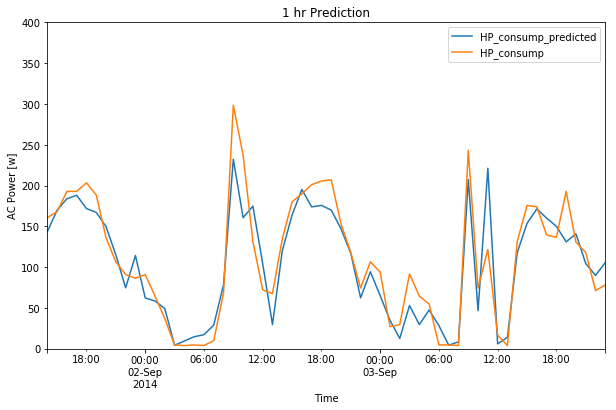

In [44]:
#Ploting linear regression results for a specifc data range
predictions_frame['2014-09-01 13:45:00':'2014-09-03 23:15:00'].plot()
plt.xlabel('Time')
plt.title("1 hr Prediction")
plt.ylabel('AC Power [w]')
plt.ylim([0,400])
plt.show()

Importing the libraries for the square error, mean error and mean square error

In [45]:
#importing metrics for the data error 
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

Calculating the squared error, mean absolute error and mean squared absuluted error

In [93]:
R2_score = r2_score(predictions_frame["HP_consump"],predictions_frame["HP_consump_predicted"])
Mean_absolute=mean_absolute_error(predictions_frame["HP_consump"],predictions_frame["HP_consump_predicted"])
Mean_absolute_square=mean_squared_error(predictions_frame["HP_consump"],predictions_frame["HP_consump_predicted"])

Showing the results of the errors

In [94]:
#showing results of data error
print " The square error of the predicted data for 1 hr  is "+str(R2_score)+"\n"
print " The mean absolute error of the predicted data for 1 hr is "+str(Mean_absolute)+"\n"
print " The mean absolute square error of the predicted data for 1 hr is "+str(Mean_absolute_square)+"\n"


 The square error of the predicted data for 1 hr  is 0.810105472656

 The mean absolute error of the predicted data for 1 hr is 27.9121771429

 The mean absolute square error of the predicted data for 1 hr is 2642.61587789



# Prediction for 24 hrs ahead

Creating the delay set up

In [73]:
#delay
delay=24

# Data lagged selected

Creating 24 hrs lagged data

In [72]:
DF_data_raw_24.head()

,main_Tot,Batt_Volt_Avg,PV_generated_Tot,HP_in_Tot,HP_out_Tot,Fantech_Tot,solar_HW_pump_Tot,HW_Tot,bathup_lts_Tot,LVL1_lts_Tot,...,bath_plg_Tot,gar_ext_lts_Tot,garage_tmp_Avg,jacuzzi_plg_Tot,dishHot_tmp_Avg,washHot_tmp_Avg,L1_heater_Tot,Tstat1_tmp_Avg,Tstat2_tmp_Avg,TV_plg_Tot
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2013-10-01 01:00:00,165.0,12.81,0.75,6.25,16.50,0.667,0.0,0.0,0.50,1.250,...,0.625,1.125,69.79,60.75,NAN,NAN,0.375,76.12,NAN,0.417
2013-10-01 02:00:00,170.0,12.81,0.75,5.00,15.75,0.667,0.0,0.0,0.50,1.250,...,0.625,1.250,69.64,59.00,NAN,NAN,0.500,76.11,NAN,0.396
2013-10-01 03:00:00,157.5,12.80,0.75,5.00,15.75,0.708,0.0,0.0,0.50,1.375,...,0.625,1.250,69.50,66.50,NAN,NAN,0.500,75.83,NAN,0.396
2013-10-01 04:00:00,157.5,12.80,0.75,5.00,15.75,0.667,0.0,0.0,0.25,1.375,...,0.625,1.125,69.38,66.25,NAN,NAN,0.500,75.62,NAN,0.396
2013-10-01 05:00:00,172.5,12.80,0.75,5.00,16.50,0.708,0.0,0.0,0.50,1.250,...,0.625,1.125,69.29,60.00,NAN,NAN,0.500,75.58,NAN,0.396


In [74]:
#Creating 24 hrs lagged data
DF_data_raw_24h=lag_columnall(DF_data_raw_24,delay,24)

In [75]:
DF_data_raw_24h.head()

,main_Tot,Batt_Volt_Avg,PV_generated_Tot,HP_in_Tot,HP_out_Tot,Fantech_Tot,solar_HW_pump_Tot,HW_Tot,bathup_lts_Tot,LVL1_lts_Tot,...,TV_plg_Tot-37hour,TV_plg_Tot-38hour,TV_plg_Tot-39hour,TV_plg_Tot-40hour,TV_plg_Tot-41hour,TV_plg_Tot-42hour,TV_plg_Tot-43hour,TV_plg_Tot-44hour,TV_plg_Tot-45hour,TV_plg_Tot-46hour
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2013-10-01 01:00:00,165.0,12.81,0.75,6.25,16.50,0.667,0.0,0.0,0.50,1.250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-01 02:00:00,170.0,12.81,0.75,5.00,15.75,0.667,0.0,0.0,0.50,1.250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-01 03:00:00,157.5,12.80,0.75,5.00,15.75,0.708,0.0,0.0,0.50,1.375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-01 04:00:00,157.5,12.80,0.75,5.00,15.75,0.667,0.0,0.0,0.25,1.375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-01 05:00:00,172.5,12.80,0.75,5.00,16.50,0.708,0.0,0.0,0.50,1.250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
#Data type conversion
DF_for_correlation24=DF_data_raw_24h.astype("float64")

# Correlation of the lagged data

Correlating the data

In [98]:
#correlation of data
correlation24=DF_for_correlation24.corr()

Saving the correlation in a .CSV file

In [99]:
DataFolderPath2 = "/Users/Marrugo/Dropbox/git_for_clone/Ac consumption prediction of ORNL Research House--MARRUGO--THOUVENIN/data_correlation24.csv"
correlation24.to_csv(DataFolderPath2,sep = ",") 

# Selected lagged data

Adding the best correlated lagged data with respect to the Heat pump consumption to the final data for a lag of 24 hrs

In [77]:
#solar radiation lagged data
Data_final24["Solar_radiation-36 hrs"]=Data_final24["Solar_radiation"].shift(36)
Data_final24["Solar_radiation-35 hrs"]=Data_final24["Solar_radiation"].shift(35)
Data_final24["Solar_radiation-34 hrs"]=Data_final24["Solar_radiation"].shift(34)

#Energy consumption lagged data
Data_final24["AC_consump-24 hrs"]=Data_final24["AC_consump"].shift(delay)
#Energy of heat pump lagged data
Data_final24["HP_consump-24 hrs"]=Data_final24["HP_consump"].shift(delay)

#temperature lagged data
Data_final24["Temperature_Avg-26 hrs"]=Data_final24["Temperature_Avg"].shift(26)
Data_final24["Temperature_Avg-25 hrs"]=Data_final24["Temperature_Avg"].shift(25)
Data_final24["Temperature_Avg-24 hrs"]=Data_final24["Temperature_Avg"].shift(24)

#relative humidity lagged data
Data_final24["Relative_Humidity-39 hrs"]=Data_final24["Relative_Humidity"].shift(39)
Data_final24["Relative_Humidity-38 hrs"]=Data_final24["Relative_Humidity"].shift(38)
Data_final24["Relative_Humidity-40 hrs"]=Data_final24["Relative_Humidity"].shift(40)

#precipitation lagged data 
Data_final24["Precipitation-45 hrs"]=Data_final24["Precipitation"].shift(45)
Data_final24["Precipitation-46 hrs"]=Data_final24["Precipitation"].shift(46)

#Roof north relative humidity lagged data 
Data_final24["RH_roof_north-24 hrs"]=Data_final24["RH_roof_north"].shift(24)
Data_final24["RH_roof_north-25 hrs"]=Data_final24["RH_roof_north"].shift(25)

#Roof north temperature lagged data 
Data_final24["RH_temp_notth-35 hrs"]=Data_final24["RH_temp_notth"].shift(35)
Data_final24["RH_temp_notth-34 hrs"]=Data_final24["RH_temp_notth"].shift(34)

#Relative humidity of story 1 lagged data 
Data_final24["RH_lvl1-24 hrs"]=Data_final24["RH_lvl1"].shift(24)

#Relative humidity of story 2  lagged data 
Data_final24["RH_lvl2-24 hrs"]=Data_final24["RH_lvl2"].shift(24)

#Relative humidity of the roof cavity lagged data 
Data_final24["RH_roof_cavity-29 hrs"]=Data_final24["RH_roof_cavity"].shift(29)
Data_final24["RH_roof_cavity-28 hrs"]=Data_final24["RH_roof_cavity"].shift(28)

Cleaning the empty values of the data 

In [78]:
Data_final24.dropna(inplace=True)
Data_final24.head()

,HP_consump,AC_consump,Temperature_Avg,Relative_Humidity,wind_speed_mean,Solar_radiation,RH_temp_notth,RH_roof_north,Precipitation,RH_roof_cavity,...,Precipitation-45 hrs,Precipitation-46 hrs,RH_roof_north-24 hrs,RH_roof_north-25 hrs,RH_temp_notth-35 hrs,RH_temp_notth-34 hrs,RH_lvl1-24 hrs,RH_lvl2-24 hrs,RH_roof_cavity-29 hrs,RH_roof_cavity-28 hrs
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2013-10-02 23:00:00,187.50,687.5,65.12,93.5,0.0,0.000,68.67,57.84,0.0,61.31,...,0.0,0.0,57.18,54.95,83.5,97.3,50.53,49.74,63.75,63.56
2013-10-03 00:00:00,15.75,257.5,64.23,93.8,0.0,0.003,66.94,59.13,0.0,61.40,...,0.0,0.0,59.01,57.18,97.3,102.9,51.54,50.75,63.56,63.68
2013-10-03 01:00:00,16.50,157.5,63.56,94.0,0.0,0.007,65.13,60.06,0.0,61.47,...,0.0,0.0,60.02,59.01,102.9,104.7,51.77,50.96,63.68,63.88
2013-10-03 02:00:00,16.50,172.5,63.39,94.1,0.0,0.037,64.54,60.22,0.0,61.69,...,0.0,0.0,60.55,60.02,104.7,102.1,51.69,51.01,63.88,63.89
2013-10-03 03:00:00,15.75,177.5,63.17,94.1,0.0,0.010,63.49,60.78,0.0,61.80,...,0.0,0.0,59.86,60.55,102.1,97.0,51.24,50.90,63.89,64.02


# Machine learning implementation

Defining the target of the random forest regression

In [79]:
DF_target24 = Data_final24["HP_consump"]

Defining the features of the random forest regression

In [80]:
DF_features24 = Data_final24.drop("HP_consump",axis=1)

Importing the train test split librery

In [81]:
#importing train test split 
from sklearn.model_selection import train_test_split

Defining the data from train and test random forest regression

In [82]:
X_train, X_test, y_train, y_test = train_test_split(DF_features24, DF_target24, test_size=0.2, random_state=41234)


Importing the random forest regression model librery

In [83]:
#importing random forest regression 
from sklearn.ensemble import RandomForestRegressor
reg2 = RandomForestRegressor()

Importing the cross validation for random forest regression 

In [84]:
#training random forest regression with cross validation 
from sklearn.model_selection import cross_val_predict

Predicting data with the test data with the model of random forest

In [85]:
predict24 = cross_val_predict(reg2,DF_features24,DF_target24,cv=25)

Creating a series data with the predicte data using the random forest model

In [86]:
predictions24 = pd.Series(predict24,index=DF_target24.index).rename("HP_consump"+'_predicted')

Creating a data frame with the predicted data and the test data

In [87]:
predictions_frame24 = predictions24.to_frame()
predictions_frame24["HP_consump"]=DF_target24

# Results

Ploting the prediction and the test data for the range of date (2014-09-01:2014-09-03)

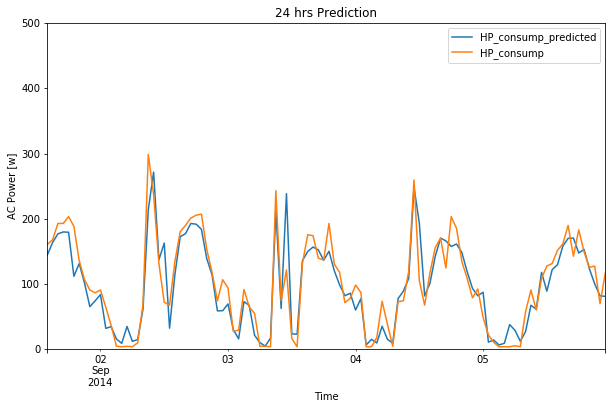

In [88]:
#Ploting linear regression results for a specifc data range
predictions_frame24['2014-09-01 13:45:00':'2014-09-05 23:15:00'].plot()
plt.xlabel('Time')
plt.title("24 hrs Prediction")
plt.ylabel('AC Power [w]')
plt.ylim([0,500])
plt.show()

Importing the libraries for the square error, mean error and mean square error

In [89]:
#importing metrics for the data error 
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

Calculating the squared error, mean absolute error and mean squared absuluted error

In [90]:
R2_score = r2_score(predictions_frame24["HP_consump"],predictions_frame24["HP_consump_predicted"])
Mean_absolute=mean_absolute_error(predictions_frame24["HP_consump"],predictions_frame24["HP_consump_predicted"])
Mean_absolute_square=mean_squared_error(predictions_frame24["HP_consump"],predictions_frame24["HP_consump_predicted"])


Showing the results of the errors

In [91]:
#showing results of data error
print " The square error of the predicted data for 24 hrs is "+str(R2_score)+"\n"
print " The mean absolute error of the predicted data for 24 hrs is "+str(Mean_absolute)+"\n"
print " The mean absolute square error of the predicted data for 24 hrs is "+str(Mean_absolute_square)+"\n"


 The square error of the predicted data for 24 hrs is 0.677076308782

 The mean absolute error of the predicted data for 24 hrs is 33.7995105577

 The mean absolute square error of the predicted data for 24 hrs is 4501.06444902

